In [27]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.dpi"] = 70

base_dir = Path().resolve().parent
data_dir = base_dir / 'data'
sys.path.append(str(base_dir))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Признаки и препроцессинг

In [11]:
data = pd.read_excel(data_dir / 'Project 2_2022.xlsx')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

features = ['Income', 'Outcome']  # Условные фичи
target = 'Balance'

train_threshold = int(data.shape[0] * 0.8)
data_train, data_test = data.iloc[:train_threshold], data.iloc[train_threshold:]
X, y = data[features], data[target]
X_train, y_train = data_train[features], data_train[target]
X_test, y_test = data_test[features], data_test[target]

## Модель

 а так же отбор признаков
 и перебор гиперпараметров

Пайплайн при фиксированной выборке:

In [25]:
from sklearn.svm import SVR
from tslib.calibrate import calibrate_model
from tslib.scoring import get_score

params = {'C': [0.1, 0.5, 1, 5, 10],
          'kernel': ['rbf', 'linear', 'poly'],
          'gamma': ['auto', 'scale']}

# Еще добавить отбор признаков

model = calibrate_model(SVR, params, X_train, y_train)

pred = model.predict(X_test)
get_score(y_test, pred)

0.5676329873807074

## Симуляция с дообучением и калибровкой

In [28]:
period_retrain_calibrate = 'M'

base_sample_size = 500  # Начальный объём выборки
sample_size = data.shape[0]

model = calibrate_model(SVR, params, X_train, y_train)

metrics = []

for new_sample_size in tqdm(range(base_sample_size, sample_size)):

    current_data_train = data.iloc[:new_sample_size]
    current_data_test = data.iloc[new_sample_size:new_sample_size+1]

    X_train, y_train = current_data_train[features], current_data_train[target]
    X_test, y_test = current_data_test[features], current_data_test[target]

    if period_retrain_calibrate == 'M':
        if X_test.index[0].day == 1:
            model = calibrate_model(SVR, params, X_train, y_train)
    else:
        raise NotImplementedError

    pred = model.predict(X_test)
    metrics.append(get_score(y_test, pred))

  0%|          | 0/1043 [00:00<?, ?it/s]

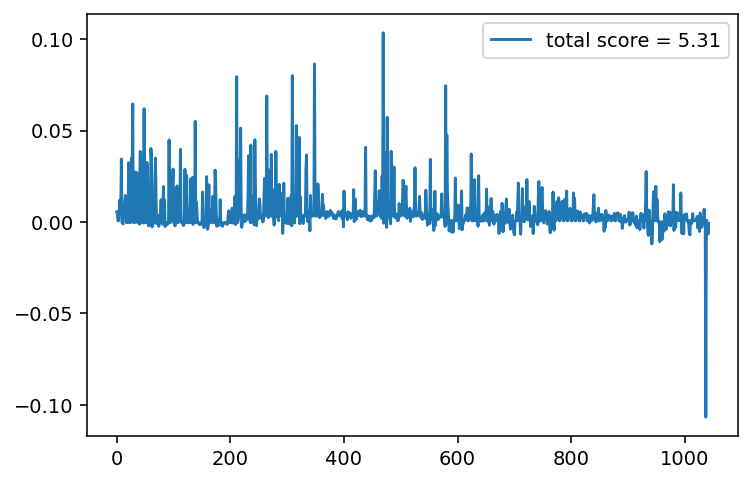

In [30]:
plt.plot(metrics, label=f'total score = {sum(metrics):.2f}')
plt.legend();